Goal:
- Select features via Random Forest

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
import datetime
import pickle
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

import statsmodels.formula.api as smf  

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

In [2]:
path = './data/merged.csv'
data = pd.read_csv(path)
data.head()

,Unnamed: 0,zip,tc_2 # OF PROPERTIES,tc_2 FY'2017 MARKET VALUE LAND,tc_2 FY'2017 MARKET VALUE TOTAL,tc_2 FY'2017 ASSESSED VALUE LAND,tc_2 FY'2017 ASSESSED VALUE TOTAL,tc_2 FY'2017 EXEMPT VALUE LAND,tc_2 FY'2017 EXEMPT VALUE TOTAL,tc_2 FY'2017 ACTUAL ASSESSED VALUE LAND,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,listingsHouseholdsRatio
0,0,10001,1471,780125048,4538886185,290671105,1658138801,81524077,686730527,320717141,...,59.5,59.5,18.6,69.3,14.9,15.9,8.6,23.6,17.2,0.010826
1,1,10002,2480,1119441624,4725893887,433821548,1705825116,194114612,763757475,449310179,...,43.2,43.1,39.4,44.4,27.9,26.1,35.0,30.5,29.7,0.006507
2,2,10003,3735,1598012608,8310198962,521608957,2700093121,33872345,198475327,537001788,...,7.6,6.3,6.3,6.3,10.5,10.4,11.0,4.1,14.2,0.006912
3,3,10004,833,86698487,644247080,33694636,239754510,326200,48617039,33694659,...,13.6,5.8,11.9,4.0,5.2,5.4,1.7,2.5,12.1,0.001906
4,4,10005,1650,371514875,1650726876,166694449,648149892,4251656,143404591,166694449,...,0.0,0.0,0.0,0.0,11.7,11.8,0.0,0.2,17.6,0.004939


In [3]:
data.head(3)

,Unnamed: 0,zip,tc_2 # OF PROPERTIES,tc_2 FY'2017 MARKET VALUE LAND,tc_2 FY'2017 MARKET VALUE TOTAL,tc_2 FY'2017 ASSESSED VALUE LAND,tc_2 FY'2017 ASSESSED VALUE TOTAL,tc_2 FY'2017 EXEMPT VALUE LAND,tc_2 FY'2017 EXEMPT VALUE TOTAL,tc_2 FY'2017 ACTUAL ASSESSED VALUE LAND,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,listingsHouseholdsRatio
0,0,10001,1471,780125048,4538886185,290671105,1658138801,81524077,686730527,320717141,...,59.5,59.5,18.6,69.3,14.9,15.9,8.6,23.6,17.2,0.010826
1,1,10002,2480,1119441624,4725893887,433821548,1705825116,194114612,763757475,449310179,...,43.2,43.1,39.4,44.4,27.9,26.1,35.0,30.5,29.7,0.006507
2,2,10003,3735,1598012608,8310198962,521608957,2700093121,33872345,198475327,537001788,...,7.6,6.3,6.3,6.3,10.5,10.4,11.0,4.1,14.2,0.006912


In [4]:
data.drop(['Unnamed: 0',  'Unnamed: 0.1','Unnamed: 0.1.1'], axis=1, inplace=True)

In [5]:
data.dtypes

zip                                                                                                                                                                                                                                                                                          int64
tc_2 # OF PROPERTIES                                                                                                                                                                                                                                                                         int64
tc_2  FY'2017 MARKET VALUE LAND                                                                                                                                                                                                                                                              int64
tc_2  FY'2017 MARKET VALUE TOTAL                                                                                               

In [6]:
data.iloc[:, 1:-1]

,tc_2 # OF PROPERTIES,tc_2 FY'2017 MARKET VALUE LAND,tc_2 FY'2017 MARKET VALUE TOTAL,tc_2 FY'2017 ASSESSED VALUE LAND,tc_2 FY'2017 ASSESSED VALUE TOTAL,tc_2 FY'2017 EXEMPT VALUE LAND,tc_2 FY'2017 EXEMPT VALUE TOTAL,tc_2 FY'2017 ACTUAL ASSESSED VALUE LAND,tc_2 FY'2017 ACTUAL ASSESSED VALUE TOTAL,tc_2 Average Actual Assessment Ratio,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
0,1471,780125048,4538886185,290671105,1658138801,81524077,686730527,320717141,1922824968,0.4236,...,20.4,59.5,59.5,18.6,69.3,14.9,15.9,8.6,23.6,17.2
1,2480,1119441624,4725893887,433821548,1705825116,194114612,763757475,449310179,1983026564,0.4196,...,30.2,43.2,43.1,39.4,44.4,27.9,26.1,35.0,30.5,29.7
2,3735,1598012608,8310198962,521608957,2700093121,33872345,198475327,537001788,3135021435,0.3772,...,10.3,7.6,6.3,6.3,6.3,10.5,10.4,11.0,4.1,14.2
3,833,86698487,644247080,33694636,239754510,326200,48617039,33694659,266505140,0.4137,...,6.8,13.6,5.8,11.9,4.0,5.2,5.4,1.7,2.5,12.1
4,1650,371514875,1650726876,166694449,648149892,4251656,143404591,166694449,738072628,0.4471,...,10.6,0.0,0.0,0.0,0.0,11.7,11.8,0.0,0.2,17.6
5,826,101857514,588687966,45183106,225926524,275650,28342340,45076938,263051395,0.4468,...,8.0,0.0,0.0,0.0,0.0,9.1,9.1,0.0,1.6,12.2
6,1839,268915290,1683011931,108061600,660503121,3735539,122876203,109410549,713241541,0.4238,...,3.2,1.1,1.1,0.0,1.5,3.7,3.4,10.2,1.5,6.8
7,1898,1207190664,5835476144,447809048,1850685006,137400763,525438213,449011850,2264977748,0.3881,...,22.8,36.1,36.0,30.3,37.7,21.2,20.7,24.1,21.5,24.4
8,2806,777864519,4503620195,318439088,1627932701,70903783,371558022,320059519,1890810974,0.4198,...,14.7,10.8,10.8,2.8,17.4,15.0,15.2,14.0,5.6,21.1
9,6469,1658433031,9423761973,560196022,3160000320,45974858,443607317,571520344,3632112779,0.3854,...,8.5,7.6,7.6,7.1,7.8,8.6,8.6,8.2,4.6,11.8


In [7]:
for i in data.columns:
    nulls = data[i].isnull().sum()
    if nulls > 0:
        print (i, data[i].isnull().sum(), '\n\n')

('tc_1 # of Properties', 12, '\n\n')
("tc_1 Finance FY'2017 Market Value Total", 12, '\n\n')
('tc_1 Average Market Value', 12, '\n\n')
("tc_1 Finance FY'2017 Assessed Value Land", 12, '\n\n')
("tc_1 Finance FY'2017 Assessed Value Total", 12, '\n\n')
('tc_1 Average Assessed Value', 12, '\n\n')
("tc_1 Finance FY'2017 Exempt Value Land", 12, '\n\n')
("tc_1 Finance FY'2017 Exempt Value Total", 12, '\n\n')
("tc_1 Finance FY'2017 Taxable Assessed Value \r\n(Assessed Value minus Exempt Value)", 12, '\n\n')
("tc_1 FY'2017 Taxes\r\n(Taxable Assessed Value * Tax Rate)", 12, '\n\n')
("tc_1 FY'2017 Average Effective Tax Rate (Taxes \xc3\xb7 Market Value)", 12, '\n\n')
("tc_1 FY'2017 Median Effective Tax Rate", 12, '\n\n')
("tc_1 FY'2017 Average Assessment Ratio\r\n(Assessed Value \xc3\xb7 Market Value)", 12, '\n\n')
("tc_1 FY'2017 Median Actual Assessment Ratio", 12, '\n\n')
("tc_1 FY'2017 Taxes w/out Exemptions", 12, '\n\n')
("tc_1 FY'2017 Average Taxes w/out Exemptions", 12, '\n\n')
("tc_1 FY'20

In [8]:
data = data.fillna(data.mean())

In [9]:
data.to_csv('./data/merged2.csv')

### Random Forest Feature Selection
Code adapted from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

In [10]:
data.drop(['bcode','note',
           'listing','geometry','Id',
           'Geography',], axis=1, inplace=True)

In [11]:
Y = data.listingsHouseholdsRatio
X = data.iloc[:, 1:-1] #select all the columns after id and geography -- the regressors
names = data.columns[7:]
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
print (feat_sort)

Features sorted by their score:
[(0.3268, 'Percent; MARITAL STATUS - Males 15 years and over - Widowed'), (0.1654, 'Percent; YEAR OF ENTRY - Population born outside the United States'), (0.05, 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later'), (0.0468, 'Percent; SEX AND AGE - 75 to 84 years'), (0.0247, 'Percent; DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION - Total Civilian Noninstitutionalized Population - With a disability'), (0.0227, 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Families - $75,000 to $99,999'), (0.0195, 'Percent; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months - Unmarried women (widowed, divorced, and never married)'), (0.0181, 'Percent; MARITAL STATUS - Females 15 years and over - Now married, except separated'), (0.0165, 'Percent; HOUSE HEATING FUEL - Occupied housing units - Bottled, tank, or LP gas'), (0.0164, 'Percent; HOUSE HEATING FUEL - Occupied housing

(0.3281, 'Percent; YEAR OF ENTRY - Population born outside the United States')   
(0.1016, 'Percent; MARITAL STATUS - Males 15 years and over - Widowed')  
(0.071199999999999999, 'Percent; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months - Unmarried women (widowed, divorced, and never married)')    
(0.045600000000000002, 'Percent; OCCUPATION - Civilian employed population 16 years and over')    
(0.034700000000000002, 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later')      
(0.034599999999999999, 'Percent; SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI) - Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed) - 15.0 to 19.9 percent')   
(0.023800000000000002, 'Percent; MARITAL STATUS - Females 15 years and over - Never married')  
(0.019599999999999999, 'Percent; MARITAL STATUS - Females 15 years and over - Now married, except separated')     
(0.019099999999999999, 'Percent; MARITAL STATUS - Males 15 years and over - Never married')  
(0.016, 'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people')  
(0.0129, 'tc_2 Taxes w/out Exemption')  
(0.0129, 'Percent; RACE - One race - Some other race')  
(0.0121, 'Percent; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services')  
(0.0117, 'Percent; SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI) - Housing unit without a mortgage (excluding units where SMOCAPI cannot be computed) - 30.0 to 34.9 percent')  
(0.0109, 'Percent; OCCUPANTS PER ROOM - Occupied housing units - 1.00 or less')  

### Fit multivariate linear regression using features selected by random forest

In [12]:
i = 0
feats = []
while feat_sort[i][0] >= .01:
    feats.append(feat_sort[i][1])
    i+= 1

print (feats)

['Percent; MARITAL STATUS - Males 15 years and over - Widowed', 'Percent; YEAR OF ENTRY - Population born outside the United States', 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later', 'Percent; SEX AND AGE - 75 to 84 years', 'Percent; DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION - Total Civilian Noninstitutionalized Population - With a disability', 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Families - $75,000 to $99,999', 'Percent; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months - Unmarried women (widowed, divorced, and never married)', 'Percent; MARITAL STATUS - Females 15 years and over - Now married, except separated', 'Percent; HOUSE HEATING FUEL - Occupied housing units - Bottled, tank, or LP gas', 'Percent; HOUSE HEATING FUEL - Occupied housing units - Coal or coke', 'Percent; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations', 'P

In [13]:
#make a new dataframe for the model with the selected feats
df = data[['listingsHouseholdsRatio']+ feats]

In [14]:
#make a dictionary of new column names for each alpha features
vals = []
for n in np.arange(len(feats)): vals.append('feat_'+str(n))
feat_keys = dict(zip(feats, vals))
print (feat_keys)

df.rename(columns=feat_keys, inplace=True)

{'Percent; SCHOOL ENROLLMENT - Population 3 years and over enrolled in school - High school (grades 9-12)': 'feat_13', 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - $75,000 to $99,999': 'feat_15', 'Percent; MARITAL STATUS - Males 15 years and over - Widowed': 'feat_0', 'Percent; HOUSE HEATING FUEL - Occupied housing units - Bottled, tank, or LP gas': 'feat_8', 'Percent; FERTILITY - Number of women 15 to 50 years old who had a birth in the past 12 months - Unmarried women (widowed, divorced, and never married)': 'feat_6', 'Percent; SEX AND AGE - 75 to 84 years': 'feat_3', 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Families - $75,000 to $99,999': 'feat_5', 'Percent; RACE - One race - Black or African American': 'feat_14', 'Percent; HOUSE HEATING FUEL - Occupied housing units - Coal or coke': 'feat_9', 'Percent; DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION - Total Civilian Noninstitutionalized Populat

C:\Program Files\Anaconda2\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [15]:
#split training and test data
train, test = train_test_split(df, test_size=0.2)

In [16]:
rgrs = train.columns[1:]

In [17]:
nmbr_rgrs = []
in_rsq = []
out_rsq = []

In [18]:
#fit model with all params
for i in np.arange(len(rgrs)):
    print (i)
    lm = smf.ols(formula='listingsHouseholdsRatio ~ '+ '+'.join(rgrs)+'-1', data = train).fit()
    nmbr_rgrs.append(len(lm.params))
    print ('Within sample R-Squared: ', lm.rsquared)
    in_rsq.append(lm.rsquared)
    print ('Out of sample R-Squared: ', r2_score(test.listingsHouseholdsRatio, lm.predict(test)))
    out_rsq.append(r2_score(test.listingsHouseholdsRatio, lm.predict(test)))
    print ('Number of model parameters: ', len(lm.params))
    drp_key = lm.pvalues.index[(np.where(lm.pvalues == lm.pvalues.max()))]
    print ('Key to drop: ', drp_key, lm.pvalues.max())
    rgrs = rgrs[rgrs != drp_key[0]]
    if lm.pvalues.max() <= 0.05:
        break

0
('Within sample R-Squared: ', 0.76210003543282956)
('Out of sample R-Squared: ', -0.19647148671623893)
('Number of model parameters: ', 16)
('Key to drop: ', Index([u'feat_10'], dtype='object'), 0.94991528812565007)
1
('Within sample R-Squared: ', 0.76209231000172939)
('Out of sample R-Squared: ', -0.19387201755600203)
('Number of model parameters: ', 15)
('Key to drop: ', Index([u'feat_3'], dtype='object'), 0.76349610285197234)
2
('Within sample R-Squared: ', 0.76191641509057884)
('Out of sample R-Squared: ', -0.16381571070689827)
('Number of model parameters: ', 14)
('Key to drop: ', Index([u'feat_5'], dtype='object'), 0.7295030643597169)
3
('Within sample R-Squared: ', 0.76168580119616425)
('Out of sample R-Squared: ', -0.12548937896350787)
('Number of model parameters: ', 13)
('Key to drop: ', Index([u'feat_15'], dtype='object'), 0.54310698255153322)
4
('Within sample R-Squared: ', 0.76097687288531757)
('Out of sample R-Squared: ', -0.12142922121278898)
('Number of model paramete

Text(0.5,0,u'Number of Regressors')

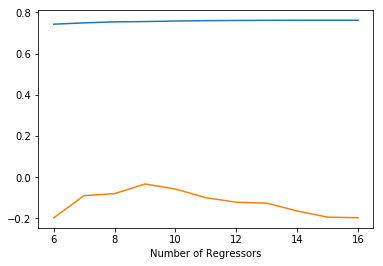

In [19]:
pl.plot(nmbr_rgrs, in_rsq, label='In sample R-Square')
pl.plot(nmbr_rgrs, out_rsq, label='Out of sample R-Square')
pl.xlabel('Number of Regressors')

In [20]:
rgrs

Index([u'feat_4', u'feat_7', u'feat_11', u'feat_12', u'feat_13'], dtype='object')

In [21]:
feat_keys[rgrs]

TypeError: unhashable type: 'Index'

In [22]:
feat_keys.values()

['feat_13',
 'feat_15',
 'feat_0',
 'feat_8',
 'feat_6',
 'feat_3',
 'feat_5',
 'feat_14',
 'feat_9',
 'feat_4',
 'feat_11',
 'feat_2',
 'feat_12',
 'feat_7',
 'feat_1',
 'feat_10']

In [23]:
#key = 
for val in rgrs:
    print (next(key for key, value in feat_keys.items() if value == val))

Percent; DISABILITY STATUS OF THE CIVILIAN NONINSTITUTIONALIZED POPULATION - Total Civilian Noninstitutionalized Population - With a disability
Percent; MARITAL STATUS - Females 15 years and over - Now married, except separated
Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959
Percent; SEX AND AGE - Total population - Male
Percent; SCHOOL ENROLLMENT - Population 3 years and over enrolled in school - High school (grades 9-12)


### Feature Selection using Lasso Regularization

In [24]:
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston
boston = load_boston()
 
rlasso = RandomizedLasso(alpha=0.00000001)
rlasso.fit(X, Y)
 
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 10), rlasso.scores_), names), reverse=True))

Features sorted by their score:
[(0.945, 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later'), (0.82, 'Percent; SCHOOL ENROLLMENT - Population 3 years and over enrolled in school - Kindergarten'), (0.77, 'Percent; SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI) - Housing units with a mortgage (excluding units where SMOCAPI cannot be computed) - Less than 20.0 percent'), (0.725, 'Percent; OCCUPANTS PER ROOM - Occupied housing units - 1.51 or more'), (0.695, 'Percent; SEX AND AGE - 65 to 74 years'), (0.68, 'Percent; MORTGAGE STATUS - Owner-occupied units - Housing units without a mortgage'), (0.67, 'Percent; RACE - Two or more races - White and American Indian and Alaska Native'), (0.67, 'Percent; ANCESTRY - Total population - Portuguese'), (0.65, 'Percent; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations'), (0.62, 'Percent; VALUE - Owner-occupied units'), (0.61, 'Percent; YEAR STRUCTURE BUILT - 